# GLMs using A&E attendance data from 2018-2022.

In this notebook we generate the GLMs for the A&E proportional based data between 2018 and 2022.

For this we will need the following packages
- pandas
- numpy
- statsmodels

We can check and download any packages required using the below.

In [1]:
!pip install pandas numpy statsmodels

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 1. Data Import

In the previous notebook (```GLMPropDataPrep.ipynb```) we shaped the data into the format that we wanted and saved it as ```AE_Prop_GLM_Data.csv```. We will now import this.

In [3]:
ProportionalData = pd.read_csv("/Users/chrisoldnall/Library/Mobile Documents/com~apple~CloudDocs/PhD/Masters Supervision/1. Hui Pheng Teoh/GitHub/Usher_AandE_Masters/Usher_AandE_Masters/data/ProcessedData/AE_Prop_GLM_Data.csv")
ProportionalData['CovidPeriod'] = ProportionalData['CovidPeriod'].astype('category')
ProportionalData['Sex'] = ProportionalData['Sex'].astype('category')

In [21]:
proportion_columns = {
    'Sex': 'SexAttendanceProportion',
    'Age': 'AgeAttendanceProportion',
    'Deprivation': 'DeprivationAttendanceProportion',
    'DepartmentType': 'DepartmentTypeAttendanceProportion',
    'HealthBoard': 'HealthBoardAttendanceProportion'
}

base_columns = ['Month', 'TotalAttendances', 'CovidPeriod', 'DateFormatted']
PivotData = ProportionalData[base_columns].drop_duplicates()

for category, proportion_column in proportion_columns.items():
    pivot_df = ProportionalData.pivot_table(
        index=base_columns,
        columns=category,
        values=proportion_column
    ).reset_index()
    pivot_df.columns = ['_'.join([str(i) for i in col]).strip() if isinstance(col, tuple) else col for col in pivot_df.columns]
    PivotData = PivotData.merge(pivot_df, on=base_columns, how='left')

PivotData.to_csv("/Users/chrisoldnall/Library/Mobile Documents/com~apple~CloudDocs/PhD/Masters Supervision/1. Hui Pheng Teoh/GitHub/Usher_AandE_Masters/Usher_AandE_Masters/data/ProcessedData/AE_Prop_Pivot_GLM_Data.csv", index=False)

# 2a. A total attendance - COVID period model.

In [30]:
formula1 = 'TotalAttendances ~ C(CovidPeriod)'
CovidPeriodModel = smf.glm(formula=formula1, 
                    data=ProportionalData, 
                    family=sm.families.Poisson(link=sm.families.links.Log())).fit()


print(CovidPeriodModel.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       TotalAttendances   No. Observations:               211680
Model:                            GLM   Df Residuals:                   211676
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1599e+08
Date:                Sun, 29 Sep 2024   Deviance:                   2.2912e+08
Time:                        14:33:58   Pearson chi2:                 2.25e+08
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              11.3737   2

In [6]:
def GLMSummary(model, baseline_label="CovidPeriod 1"):
    summary_lines = []
    # Intercept interpretation (baseline period)
    intercept = model.params['Intercept']
    intercept_exp = np.exp(intercept)
    summary_lines.append(f"GLM Summary:\n")
    summary_lines.append(f"Baseline period ({baseline_label}) has an expected number of attendances of {intercept_exp:.2f}.\n")
    # Loop through the other coefficients (excluding the Intercept)
    for variable in model.params.index:
        if variable != 'Intercept':
            coef = model.params[variable]
            coef_exp = np.exp(coef)  # Exponentiate the coefficient to interpret it in percentage terms
            p_value = model.pvalues[variable]
            # Interpret the coefficient in percentage terms
            percentage_change = (coef_exp - 1) * 100
            # Determine if it's statistically significant
            significance = "statistically significant" if p_value < 0.05 else "not statistically significant"
            # Add the interpretation to the summary
            summary_lines.append(f"For {variable}, the expected number of attendances is {coef_exp:.2f} times ")
            summary_lines.append(f"the number in the baseline period, representing a change of {percentage_change:.2f}%.\n")
            summary_lines.append(f"This result is {significance} (p-value = {p_value:.5f}).\n")
    # Join the lines and return the formatted text summary
    return ''.join(summary_lines)

In [7]:
CovidPeriodSummary = GLMSummary(CovidPeriodModel, baseline_label="CovidPeriod 1")
print(CovidPeriodSummary)
with open('/Users/chrisoldnall/Library/Mobile Documents/com~apple~CloudDocs/PhD/Masters Supervision/1. Hui Pheng Teoh/GitHub/Usher_AandE_Masters/Usher_AandE_Masters/coldnall/results/GLMSummaries/CovidPeriodSummary_Summary.txt', 'w') as f:
    f.write(CovidPeriodSummary)

GLM Summary:
Baseline period (CovidPeriod 1) has an expected number of attendances of 87000.67.
For C(CovidPeriod)[T.2], the expected number of attendances is 1.11 times the number in the baseline period, representing a change of 10.83%.
This result is statistically significant (p-value = 0.00000).
For C(CovidPeriod)[T.3], the expected number of attendances is 1.35 times the number in the baseline period, representing a change of 34.91%.
This result is statistically significant (p-value = 0.00000).
For C(CovidPeriod)[T.4], the expected number of attendances is 1.48 times the number in the baseline period, representing a change of 47.88%.
This result is statistically significant (p-value = 0.00000).



## 2b. Intermeditate models (matching Hui's R)

### Sex and COVID

In [31]:
def sanitize_column_names(df):
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('+', '_plus_') for col in df.columns]
    df.columns = [f"col_{col}" if col[0].isdigit() else col for col in df.columns]
    return df

PivotData = sanitize_column_names(PivotData)
formula2 = 'TotalAttendances ~ Female + Male + UnknownSex + C(CovidPeriod)'

SexCovidModel = smf.glm(formula=formula2, 
                data=PivotData, 
                family=sm.families.Poisson(link=sm.families.links.log())).fit()

# Display the model summary
print(SexCovidModel.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       TotalAttendances   No. Observations:                   60
Model:                            GLM   Df Residuals:                       54
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23461.
Date:                Sun, 29 Sep 2024   Deviance:                       46110.
Time:                        14:34:01   Pearson chi2:                 4.53e+04
No. Iterations:                    10   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              10.5661    

/Users/chrisoldnall/anaconda3/envs/mypython/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


### Sex, Age and COVID model.

In [37]:
formula3 = 'TotalAttendances ~ Female + Male + UnknownSex + col_18_24 + col_25_39 + col_40_64 + col_65_74 + col_75_plus + Under_18 + UnknownAge + C(CovidPeriod)'

SexAgeCovidModel = smf.glm(formula=formula3, 
                data=PivotData, 
                family=sm.families.Poisson(link=sm.families.links.log())).fit()

# Display the model summary
print(SexAgeCovidModel.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       TotalAttendances   No. Observations:                   60
Model:                            GLM   Df Residuals:                       49
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13319.
Date:                Sun, 29 Sep 2024   Deviance:                       25826.
Time:                        14:38:25   Pearson chi2:                 2.56e+04
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               9.7012    

/Users/chrisoldnall/anaconda3/envs/mypython/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


## 2b. Incorporating All Factors

In [40]:
def sanitize_column_names(df):
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('+', '_plus_') for col in df.columns]
    df.columns = [f"col_{col}" if col[0].isdigit() else col for col in df.columns]
    return df

PivotData = sanitize_column_names(PivotData)

predictor_columns = PivotData.columns.difference(['Month', 'TotalAttendances', 'CovidPeriod', 'DateFormatted'])
formula = 'TotalAttendances ~ ' + ' + '.join(predictor_columns) + ' + C(CovidPeriod)'

FullModel = smf.glm(formula=formula, 
                data=PivotData, 
                family=sm.families.Poisson(link=sm.families.links.log())).fit()

# Display the model summary
print(FullModel.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       TotalAttendances   No. Observations:                   60
Model:                            GLM   Df Residuals:                       25
Model Family:                 Poisson   Df Model:                           34
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3787.8
Date:                Sun, 29 Sep 2024   Deviance:                       6763.6
Time:                        14:50:11   Pearson chi2:                 6.75e+03
No. Iterations:                   100   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -10.68

/Users/chrisoldnall/anaconda3/envs/mypython/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [41]:
def interpret_glm_results(model):
    """
    This function generates a human-readable interpretation of the GLM results.
    
    Parameters:
    - model: The fitted GLM model object (from statsmodels).
    
    Returns:
    - A string summary interpreting the key results.
    """
    summary_lines = []
    
    # Extract the model parameters (coefficients), standard errors, and p-values
    params = model.params
    pvalues = model.pvalues
    conf_int = model.conf_int()

    summary_lines.append("GLM Summary:\n")
    
    # Interpret the Intercept (baseline)
    if 'Intercept' in params:
        intercept = params['Intercept']
        intercept_exp = np.exp(intercept)  # Exponentiate to get the effect in the original scale
        summary_lines.append(f"Baseline level (Intercept):\n")
        summary_lines.append(f"- Log-transformed expected number of attendances: {intercept:.4f}\n")
        summary_lines.append(f"- Expected number of attendances (exponentiated): {intercept_exp:.2f}\n\n")
    
    # Loop over all variables, excluding the intercept
    for variable in params.index:
        if variable == 'Intercept':
            continue  # Skip intercept
        
        coef = params[variable]
        coef_exp = np.exp(coef)  # Exponentiated coefficient to get the multiplicative effect
        p_value = pvalues[variable]
        conf_lower, conf_upper = conf_int.loc[variable]

        # Variable effect interpretation
        summary_lines.append(f"Variable: {variable}\n")
        summary_lines.append(f"- Coefficient (log scale): {coef:.4f}\n")
        summary_lines.append(f"- Exponentiated coefficient (effect on attendance): {coef_exp:.4f}\n")

        # Statistical significance
        if p_value < 0.001:
            summary_lines.append(f"- P-value: {p_value:.5f} (highly significant)\n")
        elif p_value < 0.05:
            summary_lines.append(f"- P-value: {p_value:.5f} (significant)\n")
        else:
            summary_lines.append(f"- P-value: {p_value:.5f} (not significant)\n")

        # Confidence Interval interpretation
        summary_lines.append(f"- 95% Confidence Interval (log scale): [{conf_lower:.4f}, {conf_upper:.4f}]\n")
        summary_lines.append(f"- 95% Confidence Interval (exponentiated): [{np.exp(conf_lower):.4f}, {np.exp(conf_upper):.4f}]\n\n")
    
    return ''.join(summary_lines)


interpretation = interpret_glm_results(FullModel)

# Print the interpretation summary
print(interpretation)

# # Optionally, you can save the interpretation to a file
# with open('glm_interpretation.txt', 'w') as f:
#     f.write(interpretation)

GLM Summary:
Baseline level (Intercept):
- Log-transformed expected number of attendances: -10.6842
- Expected number of attendances (exponentiated): 0.00

Variable: C(CovidPeriod)[T.2]
- Coefficient (log scale): 0.1532
- Exponentiated coefficient (effect on attendance): 1.1656
- P-value: 0.00000 (highly significant)
- 95% Confidence Interval (log scale): [0.1434, 0.1631]
- 95% Confidence Interval (exponentiated): [1.1541, 1.1772]

Variable: C(CovidPeriod)[T.3]
- Coefficient (log scale): 0.1378
- Exponentiated coefficient (effect on attendance): 1.1478
- P-value: 0.00000 (highly significant)
- 95% Confidence Interval (log scale): [0.1313, 0.1444]
- 95% Confidence Interval (exponentiated): [1.1403, 1.1554]

Variable: C(CovidPeriod)[T.4]
- Coefficient (log scale): 0.1434
- Exponentiated coefficient (effect on attendance): 1.1541
- P-value: 0.00000 (highly significant)
- 95% Confidence Interval (log scale): [0.1326, 0.1541]
- 95% Confidence Interval (exponentiated): [1.1418, 1.1666]

Vari

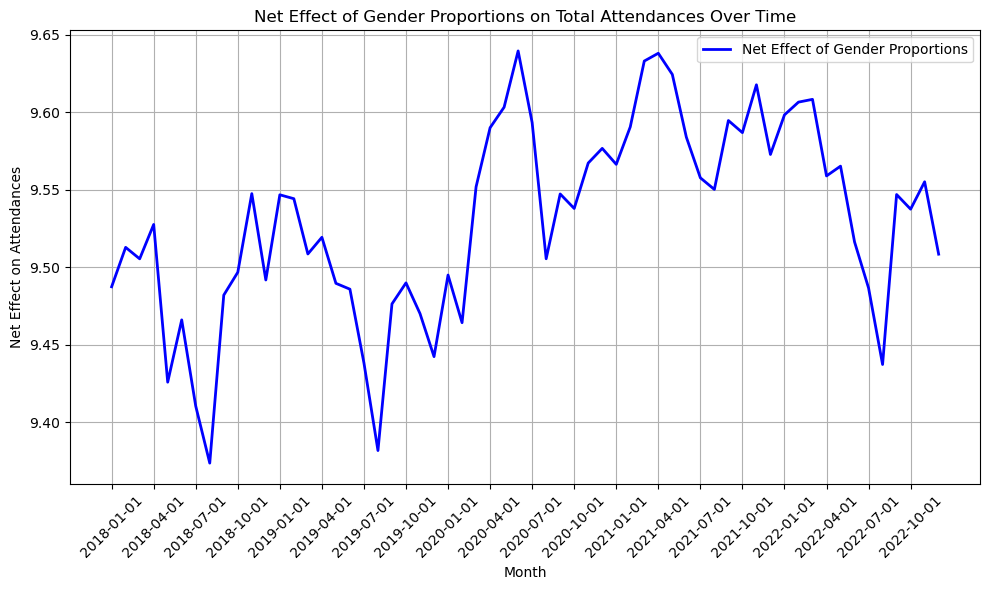

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a dataframe `gender_data` with 'Month', 'FemaleProportion', 'MaleProportion', 'UnknownSexProportion'
# and coefficients for Female, Male, and UnknownSex from your model.

# Coefficients from the model
beta_female = 2.0192  # Example coefficient for female proportion
beta_male = 2.5221    # Example coefficient for male proportion
beta_unknown = 1.2650  # Example coefficient for unknown sex proportion

# Calculate the net effect on attendances for each month
PivotData['NetEffect'] = np.exp(beta_female * PivotData['Female']) * \
                           np.exp(beta_male * PivotData['Male']) * \
                           np.exp(beta_unknown * PivotData['UnknownSex'])

# Plot the net effect over time
plt.figure(figsize=(10, 6))
plt.plot(PivotData['DateFormatted'], PivotData['NetEffect'], label='Net Effect of Gender Proportions', color='blue', linewidth=2)
plt.title('Net Effect of Gender Proportions on Total Attendances Over Time')
plt.xlabel('Month')
plt.ylabel('Net Effect on Attendances')
xticks_positions = np.arange(0, len(PivotData['DateFormatted']), 3)  # Get every 3rd index
plt.xticks(xticks_positions, PivotData['DateFormatted'][xticks_positions], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

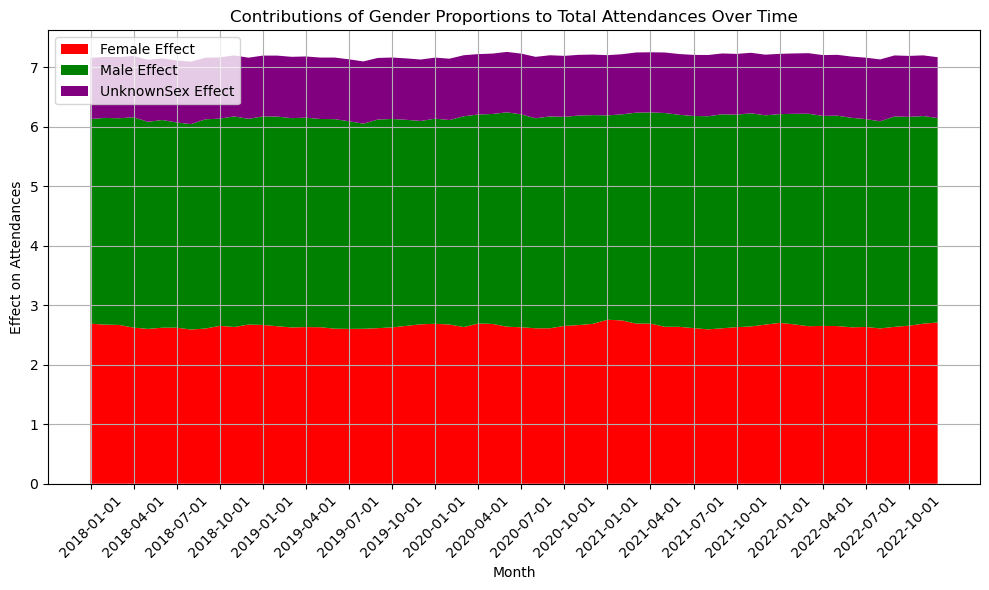

In [18]:
# Calculate individual effects for each gender
PivotData['FemaleEffect'] = np.exp(beta_female * PivotData['Female'])
PivotData['MaleEffect'] = np.exp(beta_male * PivotData['Male'])
PivotData['UnknownEffect'] = np.exp(beta_unknown * PivotData['UnknownSex'])

# Stacked area plot to visualize contributions of each gender proportion to total attendances
plt.figure(figsize=(10, 6))
plt.stackplot(PivotData['DateFormatted'], PivotData['FemaleEffect'], PivotData['MaleEffect'], PivotData['UnknownEffect'], 
              labels=['Female Effect', 'Male Effect', 'UnknownSex Effect'], colors=['red', 'green', 'purple'])

plt.title('Contributions of Gender Proportions to Total Attendances Over Time')
plt.xlabel('Month')
plt.ylabel('Effect on Attendances')
xticks_positions = np.arange(0, len(PivotData['DateFormatted']), 3)  # Get every 3rd index
plt.xticks(xticks_positions, PivotData['DateFormatted'][xticks_positions], rotation=45)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

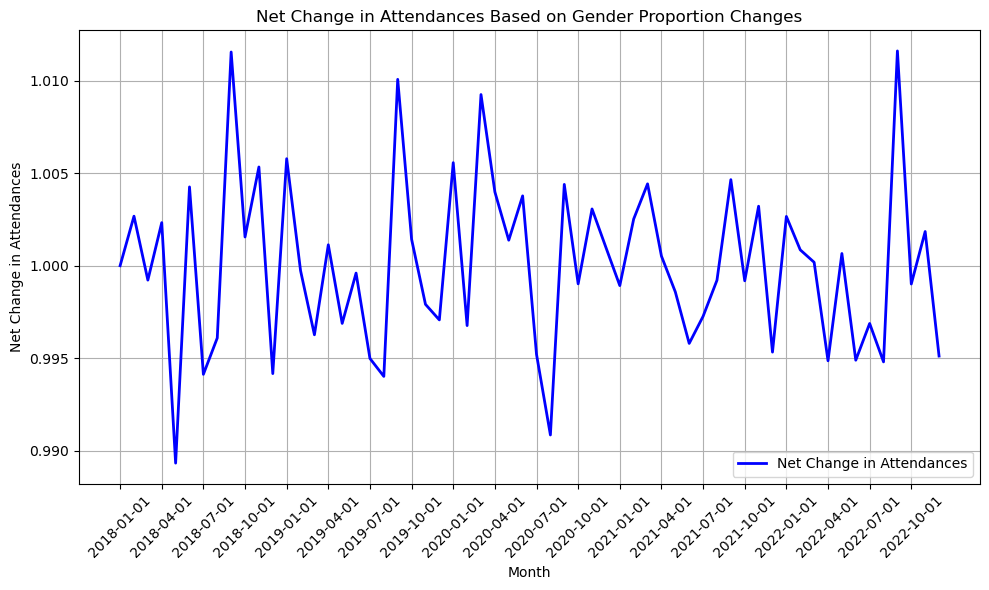

In [19]:
# Coefficients from the model
beta_female = 2.0192  # Example coefficient for female proportion
beta_male = 2.5221    # Example coefficient for male proportion
beta_unknown = 1.2650  # Example coefficient for unknown sex proportion

# Calculate changes (deltas) in gender proportions
PivotData['Delta_FemaleProportion'] = PivotData['Female'].diff().fillna(0)
PivotData['Delta_MaleProportion'] = PivotData['Male'].diff().fillna(0)
PivotData['Delta_UnknownSexProportion'] = PivotData['UnknownSex'].diff().fillna(0)

# Calculate the net change in total attendances based on proportion changes
PivotData['NetAttendanceChange'] = np.exp(beta_female * PivotData['Delta_FemaleProportion']) * \
                                     np.exp(beta_male * PivotData['Delta_MaleProportion']) * \
                                     np.exp(beta_unknown * PivotData['Delta_UnknownSexProportion'])

# Plot the net change in attendances over time
plt.figure(figsize=(10, 6))
plt.plot(PivotData['DateFormatted'], PivotData['NetAttendanceChange'], label='Net Change in Attendances', color='blue', linewidth=2)
plt.title('Net Change in Attendances Based on Gender Proportion Changes')
plt.xlabel('Month')
plt.ylabel('Net Change in Attendances')
xticks_positions = np.arange(0, len(PivotData['DateFormatted']), 3)  # Get every 3rd index
plt.xticks(xticks_positions, PivotData['DateFormatted'][xticks_positions], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

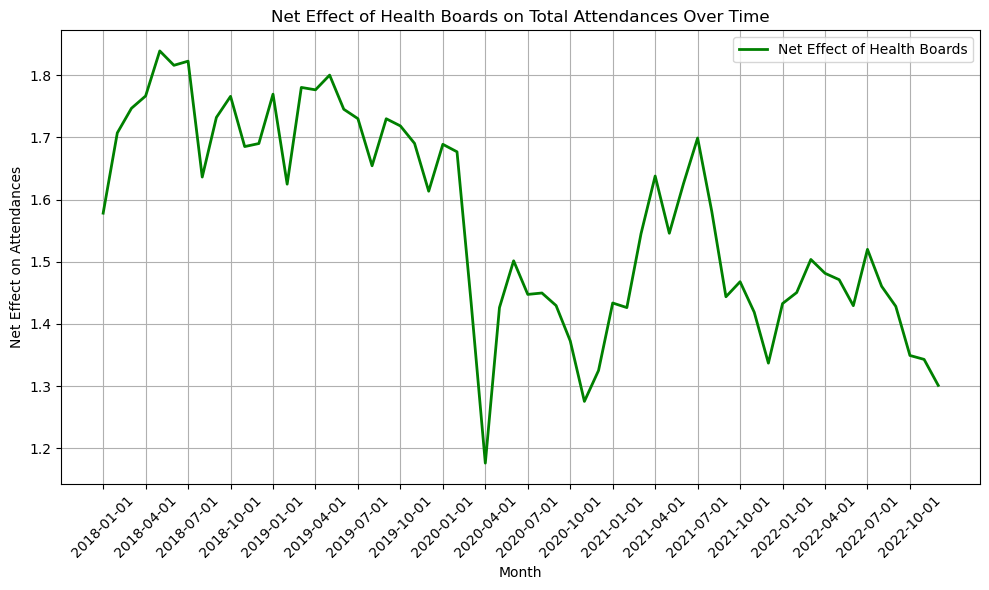

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a dataframe `PivotData` with health board proportions ('S08000015', 'S08000016', ...)
# and the corresponding coefficients from your model.

# Coefficients from the model (based on your GLM output)
beta_S08000015 = 6.4778
beta_S08000016 = -9.1968
beta_S08000017 = -7.2156
beta_S08000019 = 10.7318
beta_S08000020 = -7.6196
beta_S08000022 = -1.0653
beta_S08000024 = -8.2229
beta_S08000025 = 37.2065
beta_S08000026 = -18.9730
beta_S08000028 = -3.5433
beta_S08000029 = -2.1611
beta_S08000030 = 1.7524
beta_S08000031 = 5.7727
beta_S08000032 = 1.8629

# Calculate the net effect on attendances for each month
PivotData['NetEffectHealthBoards'] = np.exp(beta_S08000015 * PivotData['S08000015']) * \
                                     np.exp(beta_S08000016 * PivotData['S08000016']) * \
                                     np.exp(beta_S08000017 * PivotData['S08000017']) * \
                                     np.exp(beta_S08000019 * PivotData['S08000019']) * \
                                     np.exp(beta_S08000020 * PivotData['S08000020']) * \
                                     np.exp(beta_S08000022 * PivotData['S08000022']) * \
                                     np.exp(beta_S08000024 * PivotData['S08000024']) * \
                                     np.exp(beta_S08000025 * PivotData['S08000025']) * \
                                     np.exp(beta_S08000026 * PivotData['S08000026']) * \
                                     np.exp(beta_S08000028 * PivotData['S08000028']) * \
                                     np.exp(beta_S08000029 * PivotData['S08000029']) * \
                                     np.exp(beta_S08000030 * PivotData['S08000030']) * \
                                     np.exp(beta_S08000031 * PivotData['S08000031']) * \
                                     np.exp(beta_S08000032 * PivotData['S08000032'])

# Plot the net effect over time
plt.figure(figsize=(10, 6))
plt.plot(PivotData['DateFormatted'], PivotData['NetEffectHealthBoards'], label='Net Effect of Health Boards', color='green', linewidth=2)
plt.title('Net Effect of Health Boards on Total Attendances Over Time')
plt.xlabel('Month')
plt.ylabel('Net Effect on Attendances')
xticks_positions = np.arange(0, len(PivotData['DateFormatted']), 3)  # Get every 3rd index
plt.xticks(xticks_positions, PivotData['DateFormatted'][xticks_positions], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Experimental models.

## 3a. Seasonal trends via monthly incorporation.

In [44]:
PivotData = PivotData.assign(
    Year = PivotData['Month'] // 100,
    MonthNumber = PivotData['Month'] % 100)

PivotData['sin_month'] = np.sin(2 * np.pi * PivotData['MonthNumber'] / 12)
PivotData['cos_month'] = np.cos(2 * np.pi * PivotData['MonthNumber'] / 12)

SeasonalFormula = 'TotalAttendances ~ C(CovidPeriod) + sin_month + cos_month'

SeasonalModel = smf.glm(formula=SeasonalFormula, 
                data=PivotData, 
                family=sm.families.Poisson(link=sm.families.links.log())).fit()

print(SeasonalModel.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       TotalAttendances   No. Observations:                   60
Model:                            GLM   Df Residuals:                       54
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26965.
Date:                Sun, 29 Sep 2024   Deviance:                       53119.
Time:                        15:03:56   Pearson chi2:                 5.21e+04
No. Iterations:                     4   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              11.3921    

/Users/chrisoldnall/anaconda3/envs/mypython/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
